# Fake News Detection on Media Posts
We aim to develop a machine learning program to identify when a news source may be producing fake news. The model will focus on identifying fake news sources, based on multiple articles originating from a source. Once a source is labeled as a producer of fake news, we can predict with high confidence that any future articles from that source will also be fake news. Focusing on sources widens our article misclassification tolerance, because we will have multiple data points coming from each source.

The intended application of the project is for use in applying visibility weights in social media. Using weights produced by this model, social networks can make stories that are highly likely to be fake news less visible.

---

**Course No:** SDC1034

**Course Name:** Natural Language Processing Techniques [Nan Mudhalvan]

**Course Instructors**


*   Mr Balachandar
*   Dr S Umamaheswari, Associate Professor, DoIT, MIT Campus, AU.



**Team Members**

*   2022506047 - Samyukthha C S P
*   2022506051 - Dharshna R
*   2022506084 - Gowtham Rajasekaran


**IMPORTING LIBRARIES**

In [52]:
import pandas as pd
import sklearn
import itertools
import numpy as np
import seaborn as sb
import re
import nltk
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**DATA PREPERATION**

In [28]:
#data collection
#loading dataset into pandas dataframe
train_df = pd.read_csv('sample_data/train.csv')

In [29]:
train_df.head(15)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [30]:
#deleting unwanted columns
train_df = train_df.drop("author", axis = 1)
train_df = train_df.drop("title", axis = 1)
train_df = train_df.drop("id", axis = 1)

In [31]:
train_df.shape

(20800, 2)

In [32]:
train_df.head(15)

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1
5,"In these trying times, Jackie Mason is the Voi...",0
6,Ever wonder how Britain’s most iconic pop pian...,1
7,"PARIS — France chose an idealistic, traditi...",0
8,Donald J. Trump is scheduled to make a highly ...,0
9,A week before Michael T. Flynn resigned as nat...,0


In [33]:
train_df.isna().sum()

,0
text,39
label,0


<ipython-input-34-c9e58442f9da>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  return sb.countplot(x='label', data=dataFile, palette='hls')


<Axes: xlabel='label', ylabel='count'>

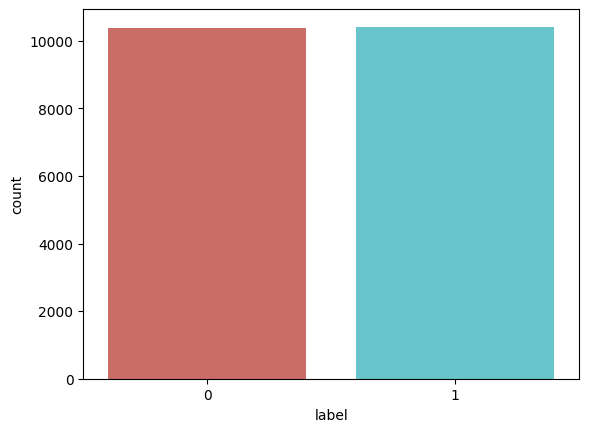

In [34]:
def create_distribution(dataFile):
    return sb.countplot(x='label', data=dataFile, palette='hls')

# by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(train_df)

In [35]:
def data_qualityCheck():
    print("Checking data qualitites...")
    train_df.isnull().sum()
    train_df.info()
    print("check finished.")
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20761 non-null  object
 1   label   20800 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 325.1+ KB
check finished.


In [36]:
train_df = train_df.dropna()

In [37]:
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
Index: 20761 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20761 non-null  object
 1   label   20761 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 486.6+ KB
check finished.


In [38]:
train_df.shape

(20761, 2)

In [39]:
train_df.head(10)

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1
5,"In these trying times, Jackie Mason is the Voi...",0
6,Ever wonder how Britain’s most iconic pop pian...,1
7,"PARIS — France chose an idealistic, traditi...",0
8,Donald J. Trump is scheduled to make a highly ...,0
9,A week before Michael T. Flynn resigned as nat...,0


In [40]:
train_df.reset_index(drop= True,inplace=True)

In [41]:
train_df.head(10)

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1
5,"In these trying times, Jackie Mason is the Voi...",0
6,Ever wonder how Britain’s most iconic pop pian...,1
7,"PARIS — France chose an idealistic, traditi...",0
8,Donald J. Trump is scheduled to make a highly ...,0
9,A week before Michael T. Flynn resigned as nat...,0


In [42]:
label_train = train_df.label

In [43]:
label_train.head(10)

,label
0,1
1,0
2,1
3,1
4,1
5,0
6,1
7,0
8,0
9,0


In [44]:
train_df = train_df.drop("label", axis = 1)

In [45]:
train_df.head(10)

,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...
1,Ever get the feeling your life circles the rou...
2,"Why the Truth Might Get You Fired October 29, ..."
3,Videos 15 Civilians Killed In Single US Airstr...
4,Print \nAn Iranian woman has been sentenced to...
5,"In these trying times, Jackie Mason is the Voi..."
6,Ever wonder how Britain’s most iconic pop pian...
7,"PARIS — France chose an idealistic, traditi..."
8,Donald J. Trump is scheduled to make a highly ...
9,A week before Michael T. Flynn resigned as nat...


In [46]:
train_df['text'][2188]

'\nThis article was written by John Vibes and originally published at Activist Post.com . \nEditor’s Comment: On the surface, there are good intentions here. The Bushes, like other patriotic establishment figures, always honor the troops, and count the sacrifices. Typically, they are stoic and praiseworthy of everything the military does. But underneath the surface, one has to wonder what is really going on inside the disturbed mind of George W. Bush – whose orders for an illegal war in Iraq, and a broader War on Terror in Afghanistan and elsewhere resulted in the deaths of thousands of U.S. troops, tens of thousands of wounded or injured and potentially more than a million civilians dead. \nDoes he feel remorse? Guilt? Has he admitted to his personal responsibility for what happened to their lives? Or do his paintings reveal a morbid sense of power over the lives of men and women whom he can only reflect upon and humanize after the fact? Considering that the Iraq war was based upon a 

**PRE PROCESSING OF DATA**

In [47]:
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('english'))

In [48]:
stpwrds

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

**LEMMATIZATION**

Lemmatization is the process of reducing words to their base or dictionary form, known as the "lemma."
In natural language processing (NLP), lemmatization is an important technique used to normalize text data by removing 			  inflections, conjugations, and other variations of a word to bring them to their root form.

         example:the word "cats" can be lemmatized to "cat",
		 	    "running" to "run",
		 	    "am" to "be"
		 	    "ate" to "eat"
Lemmatization is similar to stemming, but it produces more accurate results because it takes into account the context of the 			word in a sentence and uses more advanced linguistic analysis to identify the base form.
Lemmatization can improve the accuracy of text analysis and machine learning models that rely on text data.

In [53]:
#lemmatization
for x in range(len(train_df)) :
    corpus = []
    review = train_df['text'][x]
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    train_df['text'][x] = review

<ipython-input-53-92fdf93fc0bd>:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df['text'][x] = review


In [54]:
train_df['text'][2182]

'comment actor steven seagal stood america rest hollywood remains silent week rough country first democratic nominee hillary clinton collapsed memorial called million hardworking american deplorable werent enough nfl player throughout country blatantly disrespecting american flag needless say seagal enough think important job secretary state ensuring people dont get killed seagal tweeted cant email protected pneumonia going disastrous american people notohillary continued course seagal quickly became target liberal fire comment refused break particularly lost one twitter user tried argued hillary capable presidency capable capable leaving american die capable disregarding law capable disrespecting rape survivor argued went address race relation united state true role president barack obama played social evolution country obama abysmal race relation usa truth need start honest dialog wrote seagal concluded pointing irony attack receiving liberal everywhere best thing worldmaking one sta

**SPLITTING THE DATASET INTO TRAINING DATA & TEST DATA:**

In [55]:
#splitting the dataset to training and test dataset,80% data to be training data &20% will be testing data.(ie test_size=0.2)
X_train, X_test, Y_train, Y_test = train_test_split(train_df['text'], label_train, test_size=0.2, random_state=0)

In [56]:
X_train

,text
11948,atlanta report written notebook paper elementa...
5370,naming trump nigel farage britain marine le pe...
1179,merkel say facebook google distort perception ...
15032,germany somali muslim dont pay wabern hesse gr...
13850,hillary clinton fbi real november surprise pep...
...,...
13123,share facebook dont know fall one favorite sea...
19648,berkeley student argues free speech put studen...
9845,justice neil gorsuch seated supreme court unit...
10799,leave reply bill still good morning im still r...


In [57]:
X_train.shape

(16608,)

In [58]:
Y_train

,label
11948,0
5370,1
1179,1
15032,1
13850,1
...,...
13123,1
19648,0
9845,0
10799,1


**CONVERTING THE TEXTUAL DATA TO NUMERICAL DATA**

converting to textual data into numerical data/feature vector

1)**tf (term freequency)**:-which counts the number of time a perticular words is repearting in a documents.

2)**idf (inverse document freequency)**:-Measure the word is a rare word or common word in a document

In [59]:
#converting to textual data into numerical data/feature vector

tfidf_v = TfidfVectorizer()
tfidf_X_train = tfidf_v.fit_transform(X_train)
tfidf_X_test = tfidf_v.transform(X_test)

In [60]:
print(tfidf_X_train,tfidf_X_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4310871 stored elements and shape (16608, 146765)>
  Coords	Values
  (0, 8616)	0.03591793588221623
  (0, 109157)	0.016213715248916762
  (0, 144018)	0.02454117459499835
  (0, 90366)	0.045180464405216794
  (0, 95426)	0.025287254687813333
  (0, 38940)	0.0767252917649709
  (0, 115009)	0.180430810983907
  (0, 124990)	0.1916047023098878
  (0, 21428)	0.15423896869194717
  (0, 128879)	0.04788005784056122
  (0, 7666)	0.026869034670720694
  (0, 90490)	0.08627002006532737
  (0, 18061)	0.31270551250782314
  (0, 36666)	0.17726186939927085
  (0, 36662)	0.02655134425739942
  (0, 44303)	0.05852576065336838
  (0, 143538)	0.19213213795492906
  (0, 144044)	0.09606472084109222
  (0, 21916)	0.09417732813401164
  (0, 1373)	0.017367270232506577
  (0, 36760)	0.03198642348798466
  (0, 44904)	0.02360961444213141
  (0, 74889)	0.011589474946805104
  (0, 52002)	0.014834617493124183
  (0, 46339)	0.0386500869210021
  :	:
  (16607, 47761)	0.056774678856187

In [61]:
tfidf_X_train.shape

(16608, 146765)

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**CLASSIFICATION MODEL:-PASSIVE AGGRESSIVE CLASSIFIER**

Passive: if correct classification, keep the model; Aggressive: if incorrect classification, update to adjust to this misclassified example.

Passive-Aggressive algorithms are generally used for large-scale learning. It is one of the few 'online-learning algorithmns. In online machine learning algorithms, the input data comes in sequential order and the machine learning model is updated step-by-step, as opposed to batch learning, where the entire training dataset is used at once. This is very useful in situations where there is a huge amount of data and it is computationally infeasible to train the entire dataset because of the sheer size of the data. We can simply say that an online-leaming algorithm will get a training example, update the classifier, and then throw away the example.

In [63]:
#model and model training

classifier = PassiveAggressiveClassifier()
classifier.fit(tfidf_X_train,Y_train)

PassiveAggressiveClassifier()

**ACCURACY SCORE & CONFUSION MATRIX**

Accuracy: 95.64%
Confusion matrix, without normalization


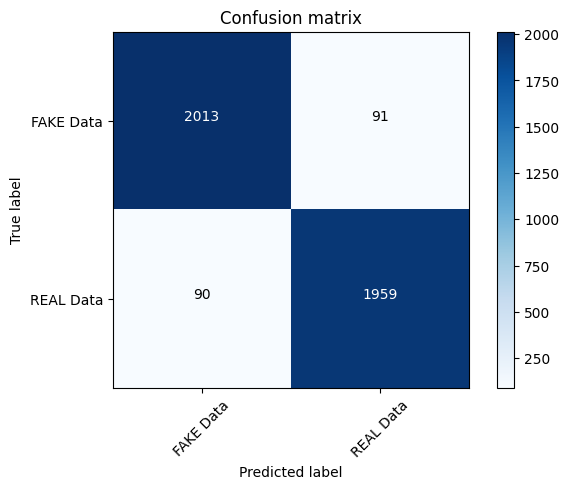

In [64]:
#accuracy score on the test data
Y_pred = classifier.predict(tfidf_X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

**CLASSIFICATION REPORT**

In [65]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2104
           1       0.96      0.96      0.96      2049

    accuracy                           0.96      4153
   macro avg       0.96      0.96      0.96      4153
weighted avg       0.96      0.96      0.96      4153



**SAVING & LOADING MODEL**

In [66]:
#pickling the model into disk
pickle.dump(classifier,open('./model.pkl', 'wb'))
pickle.dump(tfidf_v,open('vector.pkl', 'wb'))

In [67]:
# load the model from disk
loaded_model = pickle.load(open('./model.pkl', 'rb'))
#vector_form = pickle.load(open('vector.pkl', 'rb'))

**BUILDING A PREDICTIVE SYSTEM**

In [91]:
def fake_news_det(news):
    review = news
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    corpus = []
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    input_data = [' '.join(corpus)]
    vectorized_input_data = tfidf_v.transform(input_data)
    prediction = loaded_model.predict(vectorized_input_data)
    if prediction[0] == 1:
        print("Prediction of the News :  Looking Fake⚠ Post📰 \n")
    else:
        print("Prediction of the News : Looking Real Post📰 \n")


In [92]:
news=str(input("Enter the Post:"))
while(news!="nothing"):
  fake_news_det(news)
  news=str(input("Enter the Post:"))

Enter the Post:"PALO ALTO, Calif.  —   After years of scorning the political process, Silicon Valley has leapt into the fray. The prospect of a President Donald J. Trump is pushing the tech community to move beyond its traditional role as donors and to embrace a new existence as agitators and activists. A distinguished venture capital firm emblazoned on its corporate home page an earthy   epithet. One prominent tech chieftain says the consequences of Mr. Trump’s election would “range between disastrous and terrible. ” Another compares him to a dictator. And nearly 150 tech leaders signed an open letter decrying Mr. Trump and his campaign of “anger” and “bigotry. ” Not quite all the action is  . Peter Thiel, a founder of PayPal and Palantir who was the first outside investor in Facebook, spoke at the Republican convention in July. The New York Times reported on Saturday that Mr. Thiel is giving $1. 25 million to support Mr. Trump’s candidacy even as other supporters flee. (He also recen